In [ ]:
!pip install librosa
!pip install pyAudioAnalysis
!pip install eyed3
!pip install pydub
!pip install mne

     |████████████████████████████████| 52.4 MB 61 kB/s 
  Created wheel for pyAudioAnalysis: filename=pyAudioAnalysis-0.3.7-py3-none-any.whl size=52589872 sha256=5ecadd038f6c4bebef434dc2d6d452710b07468c4aa28f63a95966fa898a8f5e
  Stored in directory: /root/.cache/pip/wheels/13/5f/c1/647e78637aad4cc6a8fe907d4a1a2f86a148b70c73efd307c4
Successfully built pyAudioAnalysis
     |████████████████████████████████| 245 kB 8.7 MB/s 
     |████████████████████████████████| 242 kB 57.6 MB/s 
  Attempting uninstall: coverage
    Found existing installation: coverage 3.7.1
    Uninstalling coverage-3.7.1:
      Successfully uninstalled coverage-3.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires coverage==3.7.1, but you have coverage 5.5 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompat

In [ ]:

import pyAudioAnalysis 
import librosa
import os
import time
import numpy as np
import eyed3
import matplotlib.pyplot as plt
from pyAudioAnalysis import utilities
from pyAudioAnalysis import audioBasicIO
from pyAudioAnalysis import ShortTermFeatures
import math
import sys
from scipy.fftpack import fft
import matplotlib.pyplot as plt
from scipy.signal import lfilter
from scipy.fftpack.realtransforms import dct
from scipy.io import savemat,loadmat
import librosa.display
import numpy as np
import librosa
import sys
from collections import Counter
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE


In [ ]:
filename = '/content/drive/Shareddrives/GCPDS/databases/Databases_musica/Estímulos/002 - copia.mp3'
audio_path = filename
x , sr = librosa.load(audio_path)
print(type(x), type(sr))
x.shape

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


<class 'numpy.ndarray'> <class 'int'>


(293184,)

In [ ]:
sr

22050

# cargar funciones de cálculo de la caracterización musical

In [ ]:
eps = sys.float_info.epsilon

def dc_normalize(sig_array):
    """Removes DC and normalizes to -1, 1 range"""
    sig_array_norm = sig_array.copy()
    sig_array_norm -= sig_array_norm.mean()
    sig_array_norm /= abs(sig_array_norm).max() + 1e-10
    return sig_array_norm


def zero_crossing_rate(frame):
    """Computes zero crossing rate of frame"""
    count = len(frame)
    count_zero = np.sum(np.abs(np.diff(np.sign(frame)))) / 2
    return np.float64(count_zero) / np.float64(count - 1.0)


def energy(frame):
    """Computes signal energy of frame"""
    return np.sum(frame ** 2) / np.float64(len(frame))


def energy_entropy(frame, n_short_blocks=10):
    """Computes entropy of energy"""
    # total frame energy
    frame_energy = np.sum(frame ** 2)
    frame_length = len(frame)
    sub_win_len = int(np.floor(frame_length / n_short_blocks))
    if frame_length != sub_win_len * n_short_blocks:
        frame = frame[0:sub_win_len * n_short_blocks]

    # sub_wins is of size [n_short_blocks x L]
    sub_wins = frame.reshape(sub_win_len, n_short_blocks, order='F').copy()

    # Compute normalized sub-frame energies:
    s = np.sum(sub_wins ** 2, axis=0) / (frame_energy + eps)

    # Compute entropy of the normalized sub-frame energies:
    entropy = -np.sum(s * np.log2(s + eps))
    return entropy


""" Frequency-domain audio features """
def spectral_centroid_spread(fft_magnitude, sampling_rate):
    """Computes spectral centroid of frame (given abs(FFT))"""
    ind = (np.arange(1, len(fft_magnitude) + 1)) * \
          (sampling_rate / (2.0 * len(fft_magnitude)))

    Xt = fft_magnitude.copy()
    Xt_max = Xt.max()
    if Xt_max == 0:
        Xt = Xt / eps
    else:
        Xt = Xt / Xt_max

    NUM = np.sum(ind * Xt)
    DEN = np.sum(Xt) + eps

    # Centroid:
    centroid = (NUM / DEN)

    # Spread:
    spread = np.sqrt(np.sum(((ind - centroid) ** 2) * Xt) / DEN)

    # Normalize:
    centroid = centroid / (sampling_rate / 2.0)
    spread = spread / (sampling_rate / 2.0)

    return centroid, spread


def spectral_entropy(signal, n_short_blocks=10):
    """Computes the spectral entropy"""
    # number of frame samples
    num_frames = len(signal)

    # total spectral energy
    total_energy = np.sum(signal ** 2)

    # length of sub-frame
    sub_win_len = int(np.floor(num_frames / n_short_blocks))
    if num_frames != sub_win_len * n_short_blocks:
        signal = signal[0:sub_win_len * n_short_blocks]

    # define sub-frames (using matrix reshape)
    sub_wins = signal.reshape(sub_win_len, n_short_blocks, order='F').copy()

    # compute spectral sub-energies
    s = np.sum(sub_wins ** 2, axis=0) / (total_energy + eps)

    # compute spectral entropy
    entropy = -np.sum(s * np.log2(s + eps))

    return entropy


def spectral_flux(fft_magnitude, previous_fft_magnitude):
    """
    Computes the spectral flux feature of the current frame
    ARGUMENTS:
        fft_magnitude:            the abs(fft) of the current frame
        previous_fft_magnitude:        the abs(fft) of the previous frame
    """
    # compute the spectral flux as the sum of square distances:
    fft_sum = np.sum(fft_magnitude + eps)
    previous_fft_sum = np.sum(previous_fft_magnitude + eps)
    sp_flux = np.sum(
        (fft_magnitude / fft_sum - previous_fft_magnitude /
         previous_fft_sum) ** 2)

    return sp_flux


def spectral_rolloff(signal, c):
    """Computes spectral roll-off"""
    energy = np.sum(signal ** 2)
    fft_length = len(signal)
    threshold = c * energy
    # Ffind the spectral rolloff as the frequency position 
    # where the respective spectral energy is equal to c*totalEnergy
    cumulative_sum = np.cumsum(signal ** 2) + eps
    a = np.nonzero(cumulative_sum > threshold)[0]
    if len(a) > 0:
        sp_rolloff = np.float64(a[0]) / (float(fft_length))
    else:
        sp_rolloff = 0.0
    return sp_rolloff


def harmonic(frame, sampling_rate):
    """
    Computes harmonic ratio and pitch
    """
    m = np.round(0.016 * sampling_rate) - 1
    r = np.correlate(frame, frame, mode='full')

    g = r[len(frame) - 1]
    r = r[len(frame):-1]

    # estimate m0 (as the first zero crossing of R)
    [a, ] = np.nonzero(np.diff(np.sign(r)))

    if len(a) == 0:
        m0 = len(r) - 1
    else:
        m0 = a[0]
    if m > len(r):
        m = len(r) - 1

    gamma = np.zeros((m))
    cumulative_sum = np.cumsum(frame ** 2)
    gamma[m0:m] = r[m0:m] / (np.sqrt((g * cumulative_sum[m:m0:-1])) + eps)

    zcr = zero_crossing_rate(gamma)

    if zcr > 0.15:
        hr = 0.0
        f0 = 0.0
    else:
        if len(gamma) == 0:
            hr = 1.0
            blag = 0.0
            gamma = np.zeros((m))
        else:
            hr = np.max(gamma)
            blag = np.argmax(gamma)

        # Get fundamental frequency:
        f0 = sampling_rate / (blag + eps)
        if f0 > 5000:
            f0 = 0.0
        if hr < 0.1:
            f0 = 0.0

    return hr, f0


def mfcc_filter_banks(sampling_rate, num_fft, lowfreq=133.33, linc=200 / 3,
                      logsc=1.0711703, num_lin_filt=13, num_log_filt=27):
    """
    Computes the triangular filterbank for MFCC computation 
    (used in the stFeatureExtraction function before the stMFCC function call)
    This function is taken from the scikits.talkbox library (MIT Licence):
    https://pypi.python.org/pypi/scikits.talkbox
    """
    num_fft = int(num_fft)
    if sampling_rate < 8000:
        nlogfil = 5

    # Total number of filters
    num_filt_total = num_lin_filt + num_log_filt

    # Compute frequency points of the triangle:
    frequencies = np.zeros(num_filt_total + 2)
    frequencies[:num_lin_filt] = lowfreq + np.arange(num_lin_filt) * linc
    frequencies[num_lin_filt:] = frequencies[num_lin_filt - 1] * logsc ** \
                                 np.arange(1, num_log_filt + 3)
    heights = 2. / (frequencies[2:] - frequencies[0:-2])

    # Compute filterbank coeff (in fft domain, in bins)
    fbank = np.zeros((num_filt_total, num_fft))
    nfreqs = np.arange(num_fft) / (1. * num_fft) * sampling_rate

    for i in range(num_filt_total):
        low_freqs = frequencies[i]
        cent_freqs = frequencies[i + 1]
        high_freqs = frequencies[i + 2]

        lid = np.arange(np.floor(low_freqs * num_fft / sampling_rate) + 1,
                        np.floor(cent_freqs * num_fft / sampling_rate) + 1,
                        dtype=np.int)
        lslope = heights[i] / (cent_freqs - low_freqs)
        rid = np.arange(np.floor(cent_freqs * num_fft / sampling_rate) + 1,
                        np.floor(high_freqs * num_fft / sampling_rate) + 1,
                        dtype=np.int)
        rslope = heights[i] / (high_freqs - cent_freqs)
        fbank[i][lid] = lslope * (nfreqs[lid] - low_freqs)
        fbank[i][rid] = rslope * (high_freqs - nfreqs[rid])

    return fbank, frequencies


def mfcc(fft_magnitude, fbank, num_mfcc_feats):
    """
    Computes the MFCCs of a frame, given the fft mag
    ARGUMENTS:
        fft_magnitude:  fft magnitude abs(FFT)
        fbank:          filter bank (see mfccInitFilterBanks)
    RETURN
        ceps:           MFCCs (13 element vector)
    Note:    MFCC calculation is, in general, taken from the 
             scikits.talkbox library (MIT Licence),
    #    with a small number of modifications to make it more 
         compact and suitable for the pyAudioAnalysis Lib
    """

    mspec = np.log10(np.dot(fft_magnitude, fbank.T) + eps)
    ceps = dct(mspec, type=2, norm='ortho', axis=-1)[:num_mfcc_feats]
    return ceps


def chroma_features_init(num_fft, sampling_rate):
    """
    This function initializes the chroma matrices used in the calculation
    of the chroma features
    """
    freqs = np.array([((f + 1) * sampling_rate) /
                      (2 * num_fft) for f in range(num_fft)])
    cp = 27.50
    num_chroma = np.round(12.0 * np.log2(freqs / cp)).astype(int)

    num_freqs_per_chroma = np.zeros((num_chroma.shape[0],))

    unique_chroma = np.unique(num_chroma)
    for u in unique_chroma:
        idx = np.nonzero(num_chroma == u)
        num_freqs_per_chroma[idx] = idx[0].shape

    return num_chroma, num_freqs_per_chroma


def chroma_features(signal, sampling_rate, num_fft):
    # TODO: 1 complexity
    # TODO: 2 bug with large windows

    num_chroma, num_freqs_per_chroma = \
        chroma_features_init(num_fft, sampling_rate)
    chroma_names = ['A', 'A#', 'B', 'C', 'C#', 'D',
                    'D#', 'E', 'F', 'F#', 'G', 'G#']
    spec = signal ** 2
    if num_chroma.max() < num_chroma.shape[0]:
        C = np.zeros((num_chroma.shape[0],))
        C[num_chroma] = spec
        C /= num_freqs_per_chroma[num_chroma]
    else:
        I = np.nonzero(num_chroma > num_chroma.shape[0])[0][0]
        C = np.zeros((num_chroma.shape[0],))
        C[num_chroma[0:I - 1]] = spec
        C /= num_freqs_per_chroma
    final_matrix = np.zeros((12, 1))
    newD = int(np.ceil(C.shape[0] / 12.0) * 12)
    C2 = np.zeros((newD,))
    C2[0:C.shape[0]] = C
    C2 = C2.reshape(int(C2.shape[0] / 12), 12)
    # for i in range(12):
    #    finalC[i] = np.sum(C[i:C.shape[0]:12])
    final_matrix = np.matrix(np.sum(C2, axis=0)).T

    spec_sum = spec.sum()
    if spec_sum == 0:
        final_matrix /= eps
    else:
        final_matrix /= spec_sum

    #    ax = plt.gca()
    #    plt.hold(False)
    #    plt.plot(finalC)
    #    ax.set_xticks(range(len(chromaNames)))
    #    ax.set_xticklabels(chromaNames)
    #    xaxis = np.arange(0, 0.02, 0.01);
    #    ax.set_yticks(range(len(xaxis)))
    #    ax.set_yticklabels(xaxis)
    #    plt.show(block=False)
    #    plt.draw()

    return chroma_names, final_matrix


def chromagram(signal, sampling_rate, window, step, plot=False,
               show_progress=False):
    """
    Short-term FFT mag for spectogram estimation:
    Returns:
        a np array (num_fft x numOfShortTermWindows)
    ARGUMENTS:
        signal:      the input signal samples
        sampling_rate:          the sampling freq (in Hz)
        window:         the short-term window size (in samples)
        step:        the short-term window step (in samples)
        plot:        flag, 1 if results are to be ploted
    RETURNS:
    """
    window = int(window)
    step = int(step)
    signal = np.double(signal)
    signal = signal / (2.0 ** 15)
    signal = dc_normalize(signal)

    num_samples = len(signal)  # total number of signals
    count_fr = 0
    num_fft = int(int(window / 2))
    chromogram = np.zeros((int((num_samples-step-window) / step) + 1, 12),
                          dtype=np.float64)
    for cur_p in tqdm(range(window, num_samples - step, step),
                      disable=not show_progress):
        count_fr += 1
        x = signal[cur_p:cur_p + window]
        X = abs(fft(x))
        X = X[0:num_fft]
        X = X / len(X)
        chroma_names, chroma_feature_matrix = chroma_features(X, sampling_rate,
                                                              num_fft)
        chroma_feature_matrix = chroma_feature_matrix[:, 0]
        chromogram[count_fr-1, :] = chroma_feature_matrix.T
    freq_axis = chroma_names
    time_axis = [(t * step) / sampling_rate
                 for t in range(chromogram.shape[0])]

    if plot:
        fig, ax = plt.subplots()
        chromogram_plot = chromogram.transpose()[::-1, :]
        ratio = int(chromogram_plot.shape[1] / (3 * chromogram_plot.shape[0]))
        if ratio < 1:
            ratio = 1
        chromogram_plot = np.repeat(chromogram_plot, ratio, axis=0)
        imgplot = plt.imshow(chromogram_plot)

        ax.set_yticks(range(int(ratio / 2), len(freq_axis) * ratio, ratio))
        ax.set_yticklabels(freq_axis[::-1])
        t_step = int(count_fr / 3)
        time_ticks = range(0, count_fr, t_step)
        time_ticks_labels = ['%.2f' % (float(t * step) / sampling_rate)
                             for t in time_ticks]
        ax.set_xticks(time_ticks)
        ax.set_xticklabels(time_ticks_labels)
        ax.set_xlabel('time (secs)')
        imgplot.set_cmap('jet')
        plt.colorbar()
        plt.show()

    return chromogram, time_axis, freq_axis


def spectrogram(signal, sampling_rate, window, step, plot=False,
                show_progress=False):
    """
    Short-term FFT mag for spectogram estimation:
    Returns:
        a np array (numOfShortTermWindows x num_fft)
    ARGUMENTS:
        signal:         the input signal samples
        sampling_rate:  the sampling freq (in Hz)
        window:         the short-term window size (in samples)
        step:           the short-term window step (in samples)
        plot:           flag, 1 if results are to be ploted
        show_progress flag for showing progress using tqdm
    RETURNS:
    """
    window = int(window)
    step = int(step)
    signal = np.double(signal)
    signal = signal / (2.0 ** 15)
    signal = dc_normalize(signal)

    num_samples = len(signal)  # total number of signals
    count_fr = 0
    num_fft = int(window / 2)
    specgram = np.zeros((int((num_samples-step-window) / step) + 1, num_fft),
                        dtype=np.float64)
    for cur_p in tqdm(range(window, num_samples - step, step),
                      disable=not show_progress):
        count_fr += 1
        x = signal[cur_p:cur_p + window]
        X = abs(fft(x))
        X = X[0:num_fft]
        X = X / len(X)
        specgram[count_fr-1, :] = X

    freq_axis = [float((f + 1) * sampling_rate) / (2 * num_fft)
                 for f in range(specgram.shape[1])]
    time_axis = [float(t * step) / sampling_rate
                 for t in range(specgram.shape[0])]

    if plot:
        fig, ax = plt.subplots()
        imgplot = plt.imshow(specgram.transpose()[::-1, :])
        fstep = int(num_fft / 5.0)
        frequency_ticks = range(0, int(num_fft) + fstep, fstep)
        frequency_tick_labels = \
            [str(sampling_rate / 2 -
                 int((f * sampling_rate) / (2 * num_fft)))
             for f in frequency_ticks]
        ax.set_yticks(frequency_ticks)
        ax.set_yticklabels(frequency_tick_labels)
        t_step = int(count_fr / 3)
        time_ticks = range(0, count_fr, t_step)
        time_ticks_labels = \
            ['%.2f' % (float(t * step) / sampling_rate) for t in time_ticks]
        ax.set_xticks(time_ticks)
        ax.set_xticklabels(time_ticks_labels)
        ax.set_xlabel('time (secs)')
        ax.set_ylabel('freq (Hz)')
        imgplot.set_cmap('jet')
        plt.colorbar()
        plt.show()
    print(specgram.shape)
    return specgram, time_axis, freq_axis


# TODO
def speed_feature(signal, sampling_rate, window, step):
    signal = np.double(signal)
    signal = signal / (2.0 ** 15)
    signal = dc_normalize(signal)

    num_samples = len(signal)  # total number of signals
    cur_p = 0
    count_fr = 0

    lowfreq = 133.33
    linsc = 200 / 3.
    logsc = 1.0711703
    nlinfil = 13
    nlogfil = 27
    n_mfcc_feats = 13
    nfil = nlinfil + nlogfil
    num_fft = window / 2
    if sampling_rate < 8000:
        nlogfil = 5
        nfil = nlinfil + nlogfil
        num_fft = window / 2

    # compute filter banks for mfcc:
    fbank, freqs = mfcc_filter_banks(sampling_rate, num_fft, lowfreq, linsc,
                                       logsc, nlinfil, nlogfil)

    n_time_spectral_feats = 8
    n_harmonic_feats = 1
    n_total_feats = n_time_spectral_feats + n_mfcc_feats + n_harmonic_feats
    # st_features = np.array([], dtype=np.float64)
    st_features = []

    while cur_p + window - 1 < num_samples:
        count_fr += 1
        x = signal[cur_p:cur_p + window]
        cur_p = cur_p + step
        fft_magnitude = abs(fft(x))
        fft_magnitude = fft_magnitude[0:int(num_fft)]
        fft_magnitude = fft_magnitude / len(fft_magnitude)
        Ex = 0.0
        El = 0.0
        fft_magnitude[0:4] = 0
        #        M = np.round(0.016 * fs) - 1
        #        R = np.correlate(frame, frame, mode='full')
        st_features.append(harmonic(x, sampling_rate))
    #        for i in range(len(X)):
    # if (i < (len(X) / 8)) and (i > (len(X)/40)):
    #    Ex += X[i]*X[i]
    # El += X[i]*X[i]
    #        st_features.append(Ex / El)
    #        st_features.append(np.argmax(X))
    #        if curFV[n_time_spectral_feats+n_mfcc_feats+1]>0:
    #            print curFV[n_time_spectral_feats+n_mfcc_feats],
    #            curFV[n_time_
    #            spectral_feats+n_mfcc_feats+1]
    return np.array(st_features)


def phormants(x, sampling_rate):
    N = len(x)
    w = np.hamming(N)

    # Apply window and high pass filter.
    x1 = x * w
    x1 = lfilter([1], [1., 0.63], x1)

    # Get LPC.
    ncoeff = 2 + sampling_rate / 1000
    A, e, k = lpc(x1, ncoeff)
    # A, e, k = lpc(x1, 8)

    # Get roots.
    rts = np.roots(A)
    rts = [r for r in rts if np.imag(r) >= 0]

    # Get angles.
    angz = np.arctan2(np.imag(rts), np.real(rts))

    # Get frequencies.
    frqs = sorted(angz * (sampling_rate / (2 * math.pi)))

    return frqs


""" Windowing and feature extraction """


def feature_extraction(signal, sampling_rate, window, step, deltas=True):
    """
    This function implements the shor-term windowing process.
    For each short-term window a set of features is extracted.
    This results to a sequence of feature vectors, stored in a np matrix.
    ARGUMENTS
        signal:         the input signal samples
        sampling_rate:  the sampling freq (in Hz)
        window:         the short-term window size (in samples)
        step:           the short-term window step (in samples)
        deltas:         (opt) True/False if delta features are to be
                        computed
    RETURNS
        features (numpy.ndarray):        contains features
                                         (n_feats x numOfShortTermWindows)
        feature_names (python list):     contains feature names
                                         (n_feats x numOfShortTermWindows)
    """

    window = int(window)
    step = int(step)

    # signal normalization
    signal = np.double(signal)
    signal = signal / (2.0 ** 15)

    signal = dc_normalize(signal)

    number_of_samples = len(signal)  # total number of samples
    current_position = 0
    count_fr = 0
    num_fft = int(window / 2)

    # compute the triangular filter banks used in the mfcc calculation
    fbank, freqs = mfcc_filter_banks(sampling_rate, num_fft)

    n_time_spectral_feats = 8
    n_harmonic_feats = 0
    n_mfcc_feats = 13
    n_chroma_feats = 13
    n_total_feats = n_time_spectral_feats + n_mfcc_feats + n_harmonic_feats + \
                    n_chroma_feats
    #    n_total_feats = n_time_spectral_feats + n_mfcc_feats +
    #    n_harmonic_feats

    # define list of feature names
    feature_names = ["zcr", "energy", "energy_entropy"]
    feature_names += ["spectral_centroid", "spectral_spread"]
    feature_names.append("spectral_entropy")
    feature_names.append("spectral_flux")
    feature_names.append("spectral_rolloff")
    feature_names.append("tempo")
    feature_names += ["mfcc_{0:d}".format(mfcc_i)
                      for mfcc_i in range(1, n_mfcc_feats + 1)]
    feature_names += ["chroma_{0:d}".format(chroma_i)
                      for chroma_i in range(1, n_chroma_feats)]
    feature_names.append("chroma_std")

    # add names for delta features:
    if deltas:
        feature_names_2 = feature_names + ["delta " + f for f in feature_names]
        feature_names = feature_names_2

    features = []
    data_times = []
    # for each short-term window to end of signal
    while current_position + window - 1 < number_of_samples:
        count_fr += 1
        # get current window
        x = signal[current_position:current_position + window]
        data_times.append(x)

        # update window position
        current_position = current_position + step

        # get fft magnitude
        fft_magnitude = abs(fft(x))

        # normalize fft
        fft_magnitude = fft_magnitude[0:num_fft]
        fft_magnitude = fft_magnitude / len(fft_magnitude)

        # keep previous fft mag (used in spectral flux)
        if count_fr == 1:
            fft_magnitude_previous = fft_magnitude.copy()
        feature_vector = np.zeros((n_total_feats+1, 1))

        # zero crossing rate
        feature_vector[0] = zero_crossing_rate(x)

        # short-term energy
        feature_vector[1] = energy(x)

        # short-term entropy of energy
        feature_vector[2] = energy_entropy(x)

        # sp centroid/spread
        [feature_vector[3], feature_vector[4]] = \
            spectral_centroid_spread(fft_magnitude,
                                     sampling_rate)

        # spectral entropy
        feature_vector[5] = \
            spectral_entropy(fft_magnitude)

        # spectral flux
        feature_vector[6] = \
            spectral_flux(fft_magnitude,
                          fft_magnitude_previous)

        # spectral rolloff
        feature_vector[7] = \
            spectral_rolloff(fft_magnitude, 0.90)

        # tempo
        feature_vector[8] = librosa.beat.tempo(x,sampling_rate)
            
        # MFCCs
        mffc_feats_end = n_time_spectral_feats + n_mfcc_feats
        feature_vector[n_time_spectral_feats:mffc_feats_end, 0] = \
            mfcc(fft_magnitude, fbank, n_mfcc_feats).copy()

        # chroma features
        chroma_names, chroma_feature_matrix = \
            chroma_features(fft_magnitude, sampling_rate, num_fft)
        chroma_features_end = n_time_spectral_feats + n_mfcc_feats + \
                              n_chroma_feats - 1
        feature_vector[mffc_feats_end:chroma_features_end] = \
            chroma_feature_matrix
        feature_vector[chroma_features_end] = chroma_feature_matrix.std()
        if not deltas:
            features.append(feature_vector)
        else:
            # delta features
            if count_fr > 1:
                delta = feature_vector - feature_vector_prev
                feature_vector_2 = np.concatenate((feature_vector, delta))
            else:
                feature_vector_2 = np.concatenate((feature_vector,
                                                   np.zeros(feature_vector.
                                                            shape)))
            feature_vector_prev = feature_vector
            features.append(feature_vector_2)

        fft_magnitude_previous = fft_magnitude.copy()
        
        
    features = np.concatenate(features, 1)
    return features, feature_names,data_times

def estimate_pitch(segment, sr, fmin=50.0, fmax=2000.0):
    
    # Compute autocorrelation of input segment.
    r = librosa.autocorrelate(segment)
    
    # Define lower and upper limits for the autocorrelation argmax.
    i_min = sr/fmax
    i_max = sr/fmin
    r[:int(i_min)] = 0
    r[int(i_max):] = 0
    
    # Find the location of the maximum autocorrelation.
    i = r.argmax()
    f0 = float(sr)/i
    return f0



/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


[161.49902344]
[161.49902344]
26


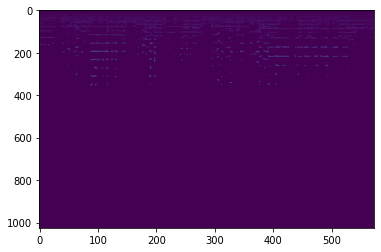

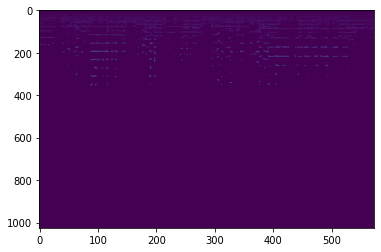

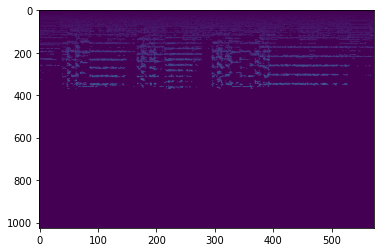

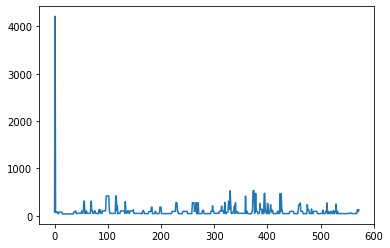

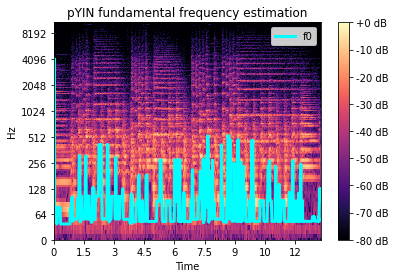

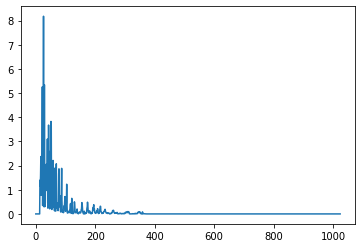

In [ ]:
filename = '/content/drive/Shareddrives/GCPDS/databases/Databases_musica/Estímulos/002 - copia.mp3'
audio_path = filename
x , sr = librosa.load(audio_path)
# extraer varias características
a_ = feature_extraction(x,sr,sr,sr*0.5)

# extraer tempo
tempo = librosa.beat.tempo(x, sr=sr)
print(tempo)
onset_env = librosa.onset.onset_strength(x, sr=sr)
tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)
print(tempo)

# extraer pitch
pitches, magnitudes = librosa.piptrack(y=x, sr=sr)
plt.figure()
plt.imshow(pitches,aspect='auto')
S = np.abs(librosa.stft(x))
plt.figure()
pitches, magnitudes = librosa.piptrack(S=S, sr=sr)
plt.imshow(pitches,aspect='auto')
plt.figure()
pitches, magnitudes = librosa.piptrack(S=S, sr=sr, threshold=1, ref=np.mean)
plt.imshow(pitches,aspect='auto')

#  Computing a fundamental frequency (F0) curve from an audio input
f0 = librosa.yin(x, 40, 5000)
plt.figure()
plt.plot(f0)
times = librosa.times_like(f0)
D = librosa.amplitude_to_db(np.abs(librosa.stft(x)), ref=np.max)
fig, ax = plt.subplots()
img = librosa.display.specshow(D, x_axis='time', y_axis='log', ax=ax)
ax.set(title='pYIN fundamental frequency estimation')
fig.colorbar(img, ax=ax, format="%+2.f dB")
ax.plot(times, f0, label='f0', color='cyan', linewidth=3)
ax.legend(loc='upper right')

plt.figure()
plt.plot(np.mean(magnitudes,axis=1))
print(np.argmax(np.mean(magnitudes,axis=1)))

# Prueba con tempo

In [ ]:
sr

22050

In [ ]:
# import os
import numpy as np
import os
path = '/content/drive/Shareddrives/GCPDS/databases/Databases_musica/Estímulos/'
arch = os.listdir(path=path)

arch.sort()
# fs = 1000.0
no_   = list()
temppo= list()
# temppo_v = list()
harmo = list()
tempo = list()
pitch_= list()
pos   = 0
features= list()
window= sr
step  = window*0.5
windows = list(np.arange(0,221760-window,step))
for ar in arch:
  harmo_v = list()
  temppo_v= list()
  features_v = list()
  pitch_v = list()
  for time in range(len(windows)):
    # try:
    filename = path+ar
    x, sr = librosa.load(filename)
    X_ = x[int(windows[time]):int(windows[time]+window)]
    print(filename)
    frame_sz = sr
    step = frame_sz*0.5
    # tempo.append(numpy.array([librosa.beat.tempo(x[i:int(i+frame_sz)], sr) for i in onset_samples]))
    temp =  feature_extraction(X_,sr,sr,sr*0.5)
    features.append(temp)

    # temporal = []
    # for i in range(len(temp[2])):
      # temporal.append(librosa.beat.tempo(X_,sr))
    # temppo_v.append(temporal)
    temppo_v.append(librosa.beat.tempo(X_,sr))

    temporal = []
    for i in range(len(temp[2])):
      temporal.append(estimate_pitch(X_, sr, fmin=10.0, fmax=15000.0))
    pitch_v.append(temporal)

    harmo_v.append(librosa.yin(X_, 40, 5000))
  pitch_.append(pitch_v)
  harmo.append(harmo_v)
  temppo.append(temppo_v)
  features_v.append(features)
    # print(features[pos])
    # except:
      # filename = path+ar
      # x, sr = librosa.load(filename)
      # print(filename)
      # onset_frames = librosa.onset.onset_detect(x, sr=sr)-1 # , delta=0.04, wait=4
      # onset_times  = librosa.frames_to_time(onset_frames, sr=sr)
      # onset_samples= librosa.frames_to_samples(onset_frames)
      # frame_sz = fs*0.090
      # tempo.append(librosa.beat.tempo(x, sr=sr))
      # temp = numpy.array([extract_features(x[i:int(i+frame_sz)], sr) for i in onset_samples])
      # features.append(temp)
      # print(features[pos].shape)
    # pos += 1

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
x.shape

(293184,)

In [ ]:
len(features_v)

NameError: ignored

## cargar información de los trials

In [ ]:
trials = loadmat('/content/Trials_.mat')
trial = trials['trials']
trial

array([[ 62, 163, 160, ..., 329, 282, 331],
       [ 25, 165,  28, ..., 151, 176,  90],
       [ 69,  45, 214, ...,  83, 154,  74],
       ...,
       [ 62, 163, 160, ..., 312, 310, 315],
       [ 62, 163, 160, ..., 251, 326, 125],
       [ 62, 163, 160, ..., 335,  71, 276]], dtype=int32)

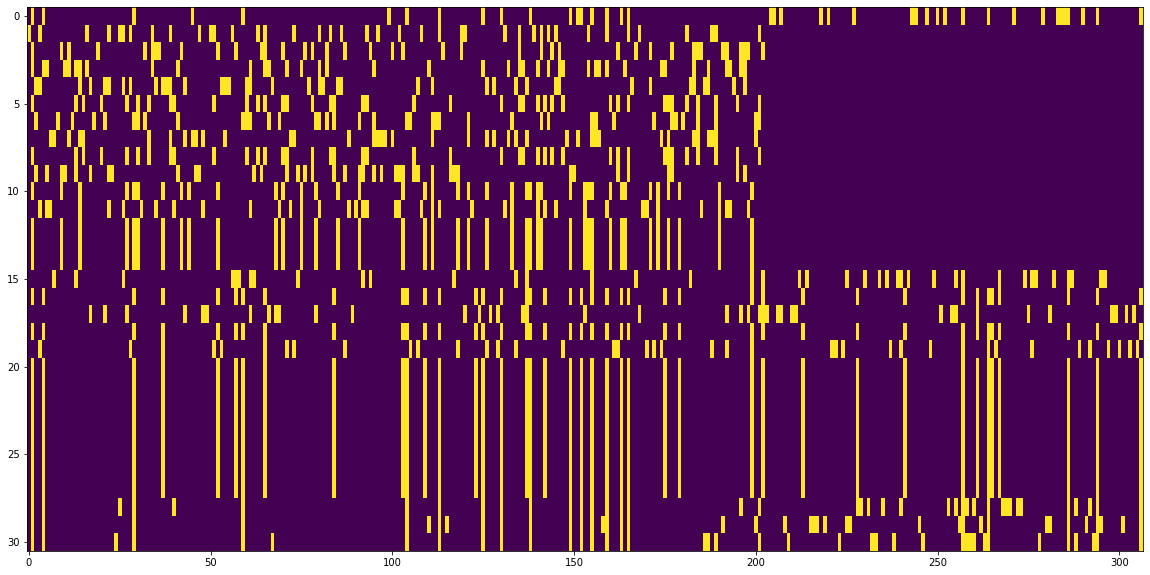

In [ ]:
est = loadmat('/content/esti.mat')
plt.figure(figsize=(20,10))
plt.imshow(est['esti'],aspect='auto',cmap='viridis')
esti = est['esti']

# Prueba de selección de grupos

In [ ]:
np.array(a_[1]).T

array(['zcr', 'energy', 'energy_entropy', 'spectral_centroid',
       'spectral_spread', 'spectral_entropy', 'spectral_flux',
       'spectral_rolloff', 'tempo', 'mfcc_1', 'mfcc_2', 'mfcc_3',
       'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9',
       'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'chroma_1', 'chroma_2',
       'chroma_3', 'chroma_4', 'chroma_5', 'chroma_6', 'chroma_7',
       'chroma_8', 'chroma_9', 'chroma_10', 'chroma_11', 'chroma_12',
       'chroma_std', 'delta zcr', 'delta energy', 'delta energy_entropy',
       'delta spectral_centroid', 'delta spectral_spread',
       'delta spectral_entropy', 'delta spectral_flux',
       'delta spectral_rolloff', 'delta tempo', 'delta mfcc_1',
       'delta mfcc_2', 'delta mfcc_3', 'delta mfcc_4', 'delta mfcc_5',
       'delta mfcc_6', 'delta mfcc_7', 'delta mfcc_8', 'delta mfcc_9',
       'delta mfcc_10', 'delta mfcc_11', 'delta mfcc_12', 'delta mfcc_13',
       'delta chroma_1', 'delta chroma_2', 'delta chroma_3'

In [ ]:
pos__ = list(np.zeros((len(a_[1]))))
posi = [8] # 35,36
for po in posi:
  pos__[po] = 1
pos__ = np.asarray(pos__).astype(bool)
np.asarray(a_[1])[pos__] #0,1,2,3,5,34,35,36

array(['tempo'], dtype='<U23')

In [ ]:
feature3 = list()
tam_ = list()
import numpy as np
for feat in range(len(features)):
  # tem = np.mean(features[feat][0][pos,:],axis=1)
  # tem = np.concatenate(features[feat][0][pos__,:],axis=0)
  tem = np.concatenate(temppo_v[feat])
  # feature3.append(np.concatenate(np.asarray([tem,tempo[feat]])))
  # feature3.append(np.co.ncatenate(np.asarray([tem)))
  feature3.append(tem)
  # feature_.append(np.concatenate(features[feat],axis=0))
  tam_.append(feature3[feat].shape)

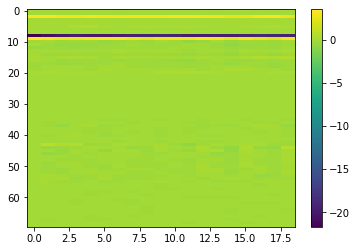

In [ ]:
plt.imshow(features[0][0],aspect='auto')
plt.colorbar()

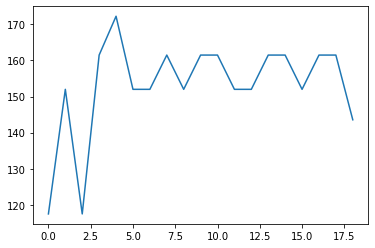

In [ ]:
plt.plot(feature3[0])

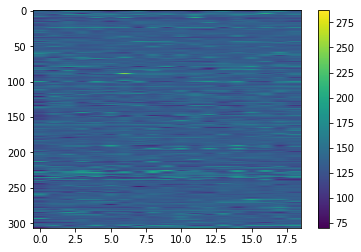

In [ ]:
plt.imshow(np.asarray(feature3),aspect='auto')
plt.colorbar()

In [ ]:
np.asarray(feature3).shape

(307, 19)

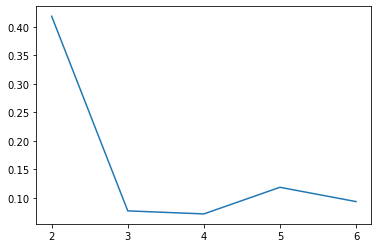

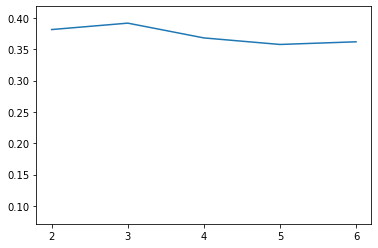

In [ ]:
n_clusters= 7
data = np.asarray(feature3)
silhouette_score_cluster = list()
for a in range(2,n_clusters):
  km=KMeans(n_clusters=a,
            # init='k-means++',
            # n_init=10,
            # max_iter=300,
            # tol=1e-4,
            random_state=0)
  y_km=km.fit_predict(data)
  silhouette_score_cluster.append(silhouette_score(data,km.labels_))
dat_tem = silhouette_score_cluster
plt.plot(silhouette_score_cluster)
plt.xticks([0,1,2,3,4], [2,3,4,5,6])
plt.show()

dato_org = TSNE(n_components=2,random_state=0,perplexity=10).fit_transform(data)
n_clusters= 7
silhouette_score_cluster = list()
for a in range(2,n_clusters):
  km=KMeans(n_clusters=a,
            # init='k-means++',
            # n_init=10,
            # max_iter=300,
            # tol=1e-4,
            random_state=0)
  y_km=km.fit_predict(dato_org)
  silhouette_score_cluster.append(silhouette_score(dato_org,km.labels_))
dat_tem.extend(silhouette_score_cluster)
plt.plot(silhouette_score_cluster)
plt.xticks([0,1,2,3,4], [2,3,4,5,6])
plt.ylim([np.min(dat_tem),np.max(dat_tem)])
plt.show()

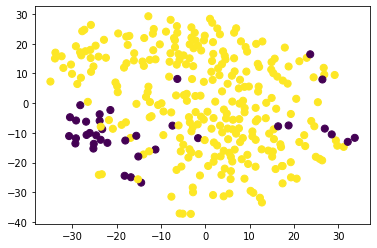

In [ ]:
dato_org = TSNE(n_components=2,random_state=0,perplexity=10).fit_transform(data)
# for a in range(2,n_clusters):
km = KMeans(n_clusters=2,
            # init='k-means++',
            # n_init=10,
            # max_iter=300,
            # tol=1e-4,
            random_state=0)
y_km=km.fit_predict(data)
plt.figure()
plt.scatter(dato_org[:,0],dato_org[:,1],c=y_km,
            s=50, cmap='viridis')

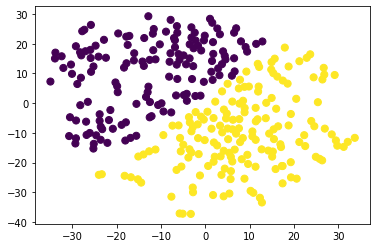

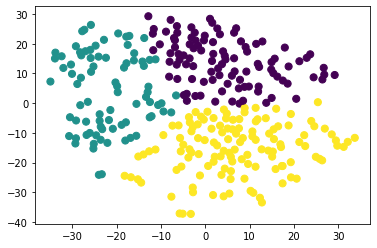

In [ ]:
dato_org = TSNE(n_components=2,random_state=0,perplexity=10).fit_transform(data)
# for a in range(2,n_clusters):
km = KMeans(n_clusters=2,
            # init='k-means++',
            # n_init=10,
            # max_iter=300,
            # tol=1e-4,
            random_state=0)
y_km=km.fit_predict(dato_org)
plt.figure()
plt.scatter(dato_org[:,0],dato_org[:,1],c=y_km,
            s=50, cmap='viridis')
y_km_t_2 = y_km
# plt.title('N_clustering'+str(a))
dato_org = TSNE(n_components=2,random_state=0,perplexity=10).fit_transform(data)
# for a in range(2,n_clusters):
km = KMeans(n_clusters=3,
            # init='k-means++',
            # n_init=10,
            # max_iter=300,
            # tol=1e-4,
            random_state=0)
y_km=km.fit_predict(dato_org)
plt.figure()
plt.scatter(dato_org[:,0],dato_org[:,1],c=y_km,
            s=50, cmap='viridis')
y_km_t_3 = y_km
# plt.title('N_clustering'+str(a))

In [ ]:
mean_tempo = np.mean(data,axis=1)
print(np.max(mean_tempo[y_km==1]))
print(np.min(mean_tempo[y_km==1]))
print(np.max(mean_tempo[y_km==0]))
print(np.min(mean_tempo[y_km==0]))

163.6703697407314
120.05578532168927
150.62422779998744
127.60881524587569


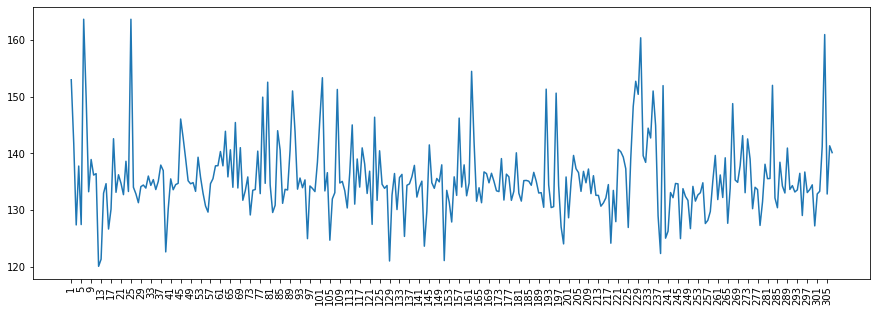

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(np.mean(data,axis=1))
plt.xticks(list(np.arange(0,307,4)),list(np.arange(1,308,4)),rotation=90)
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


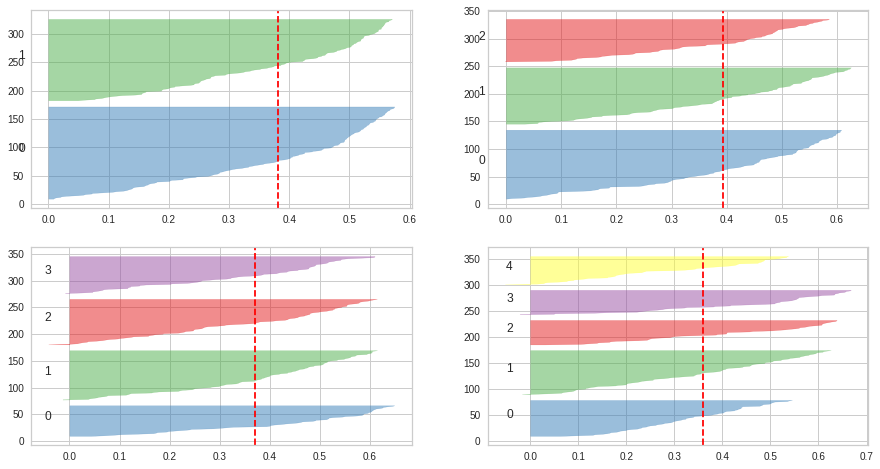

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer
fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(dato_org)

# Estimación del Pitch

In [ ]:
feature4 = list()
tam_ = list()
import numpy as np
for feat in range(len(features)):
  # tem = np.mean(features[feat][0][pos,:],axis=1)
  # tem = np.concatenate(features[feat][0][pos__,:],axis=0)
  tem = np.concatenate(harmo[feat].reshape(-1,1))
  # feature3.append(np.concatenate(np.asarray([tem,tempo[feat]])))
  # feature3.append(np.co.ncatenate(np.asarray([tem)))
  feature4.append(tem)
  # feature_.append(np.concatenate(features[feat],axis=0))
  tam_.append(feature4[feat].shape)

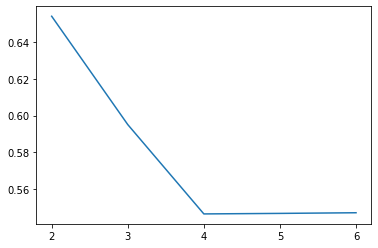

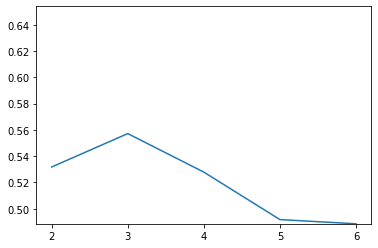

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
n_clusters= 7
data = np.asarray(feature4)
silhouette_score_cluster = list()
for a in range(2,n_clusters):
  km=KMeans(n_clusters=a,
            # init='k-means++',
            # n_init=10,
            # max_iter=300,
            # tol=1e-4,
            random_state=0)
  y_km=km.fit_predict(data)
  silhouette_score_cluster.append(silhouette_score(data,km.labels_))
dat_tem = silhouette_score_cluster
plt.plot(silhouette_score_cluster)
plt.xticks([0,1,2,3,4], [2,3,4,5,6])
plt.show()

n_clusters= 7
data = np.asarray(feature4)
silhouette_score_cluster = list()
dato_org = TSNE(n_components=2,random_state=0,perplexity=15).fit_transform(data)
for a in range(2,n_clusters):
  km=KMeans(n_clusters=a,
            # init='k-means++',
            # n_init=10,
            # max_iter=300,
            # tol=1e-4,
            random_state=0)
  y_km=km.fit_predict(dato_org)
  silhouette_score_cluster.append(silhouette_score(dato_org,km.labels_))
dat_tem.extend(silhouette_score_cluster)
plt.plot(silhouette_score_cluster)
plt.xticks([0,1,2,3,4], [2,3,4,5,6])
plt.ylim([np.min(dat_tem),np.max(dat_tem)])
plt.show()

In [ ]:
XT_norm_ = np.zeros((data.shape))
for k in range(data.shape[0]):
  XT_norm_[k,:] = (data[k,:]-data[k,:].min())/(data[k,:].max()-data[k,:].min())
data = XT_norm_

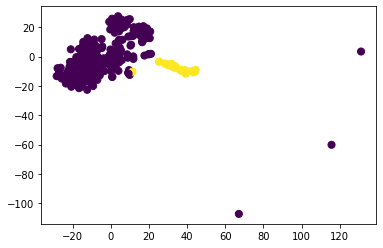

In [ ]:
dato_org = TSNE(n_components=2,random_state=0,perplexity=10).fit_transform(data)
# for a in range(2,n_clusters):
km = KMeans(n_clusters=2,
            # init='k-means++',
            # n_init=10,
            # max_iter=300,
            # tol=1e-4,
            random_state=0)
y_km=km.fit_predict(data)
plt.figure()
plt.scatter(dato_org[:,0],dato_org[:,1],c=y_km,
            s=50, cmap='viridis')

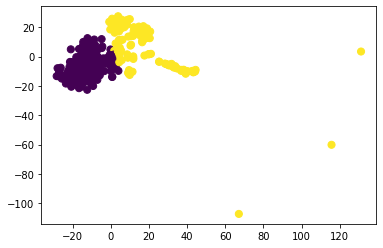

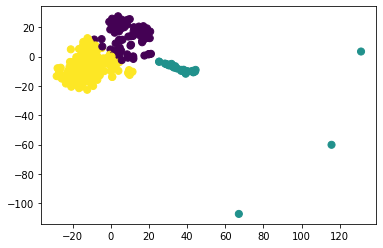

In [ ]:
dato_org = TSNE(n_components=2,random_state=0,perplexity=10).fit_transform(data)
# for a in range(2,n_clusters):
km = KMeans(n_clusters=2,
            # init='k-means++',
            # n_init=10,
            # max_iter=300,
            # tol=1e-4,
            random_state=0)
y_km=km.fit_predict(dato_org)
plt.figure()
plt.scatter(dato_org[:,0],dato_org[:,1],c=y_km,
            s=50, cmap='viridis')
y_km_f_2 = y_km
# plt.title('N_clustering'+str(a))

dato_org = TSNE(n_components=2,random_state=0,perplexity=10).fit_transform(data)
# for a in range(2,n_clusters):
km = KMeans(n_clusters=3,
            # init='k-means++',
            # n_init=10,
            # max_iter=300,
            # tol=1e-4,
            random_state=0)
y_km=km.fit_predict(dato_org)
plt.figure()
plt.scatter(dato_org[:,0],dato_org[:,1],c=y_km,
            s=50, cmap='viridis')
y_km_f_3 = y_km
# plt.title('N_clustering'+str(a))

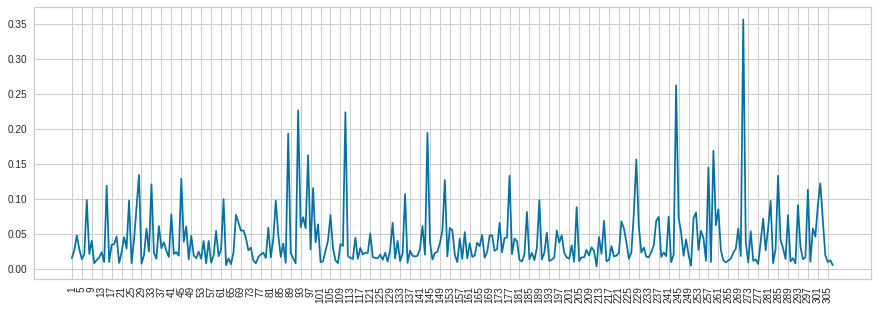

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(np.mean(data,axis=1))
plt.xticks(list(np.arange(0,307,4)),list(np.arange(1,308,4)),rotation=90)
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


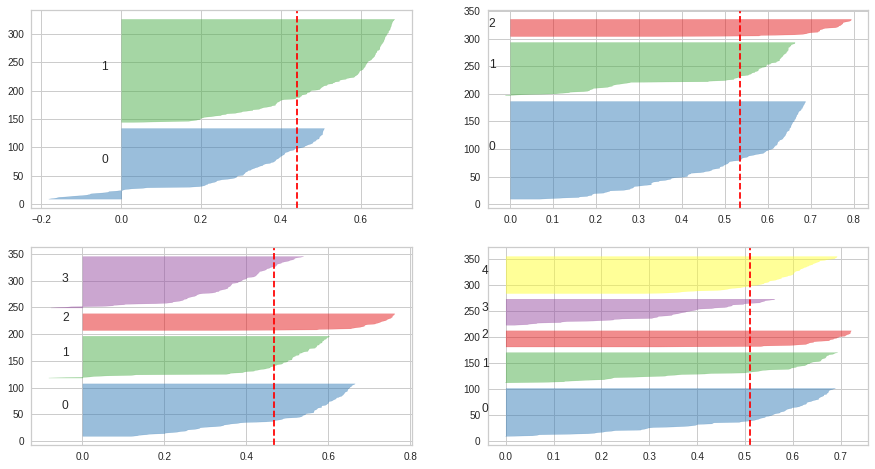

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer
fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(dato_org)

# estimación energia

In [ ]:
pos__ = list(np.zeros((len(a_[1]))))
posi = [1] # 35,36
for po in posi:
  pos__[po] = 1
pos__ = np.asarray(pos__).astype(bool)
np.asarray(a_[1])[pos__] #0,1,2,3,5,34,35,36

array(['energy'], dtype='<U23')

In [ ]:
feature5 = list()
tam_ = list()
import numpy as np
for feat in range(len(features)):
  # tem = np.mean(features[feat][0][pos,:],axis=1)
  tem = np.concatenate(features[feat][0][pos__,:],axis=0)
  # tem = np.concatenate(temppo_v[feat])
  # feature3.append(np.concatenate(np.asarray([tem,tempo[feat]])))
  # feature3.append(np.co.ncatenate(np.asarray([tem)))
  feature5.append(tem)
  # feature_.append(np.concatenate(features[feat],axis=0))
  tam_.append(feature5[feat].shape)

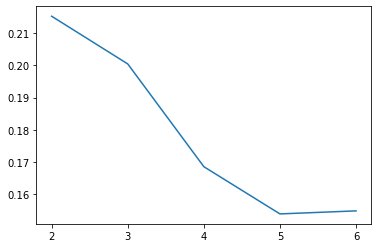

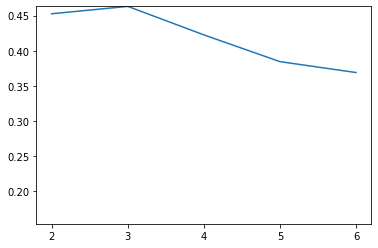

In [ ]:
n_clusters= 7
data = np.asarray(feature5)
silhouette_score_cluster = list()
dato_org = TSNE(n_components=2,random_state=0,perplexity=10).fit_transform(data)
for a in range(2,n_clusters):
  km=KMeans(n_clusters=a,
            # init='k-means++',
            # n_init=10,
            # max_iter=300,
            # tol=1e-4,
            random_state=0)
  y_km=km.fit_predict(data)
  silhouette_score_cluster.append(silhouette_score(data,km.labels_))
dat_tem = silhouette_score_cluster
plt.plot(silhouette_score_cluster)
plt.xticks([0,1,2,3,4], [2,3,4,5,6])
plt.show()

silhouette_score_cluster = list()
for a in range(2,n_clusters):
  km=KMeans(n_clusters=a,
            # init='k-means++',
            # n_init=10,
            # max_iter=300,
            # tol=1e-4,
            random_state=0)
  y_km=km.fit_predict(dato_org)
  silhouette_score_cluster.append(silhouette_score(dato_org,km.labels_))
dat_tem.extend(silhouette_score_cluster)
plt.plot(silhouette_score_cluster)
plt.xticks([0,1,2,3,4], [2,3,4,5,6])
plt.ylim([np.min(dat_tem),np.max(dat_tem)])
plt.show()

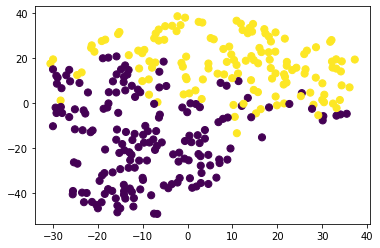

In [ ]:
dato_org = TSNE(n_components=2,random_state=0,perplexity=10).fit_transform(data)
# for a in range(2,n_clusters):
km = KMeans(n_clusters=2,
            # init='k-means++',
            # n_init=10,
            # max_iter=300,
            # tol=1e-4,
            random_state=0)
y_km=km.fit_predict(data)
plt.figure()
plt.scatter(dato_org[:,0],dato_org[:,1],c=y_km,
            s=50, cmap='viridis')

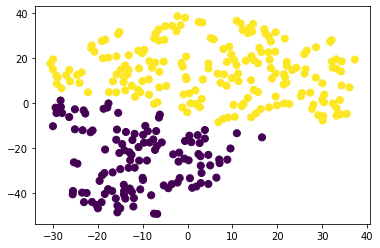

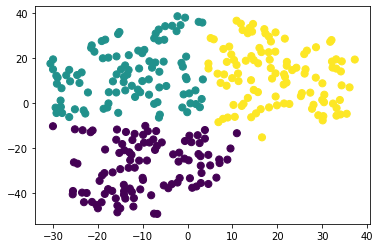

In [ ]:
dato_org = TSNE(n_components=2,random_state=0,perplexity=10).fit_transform(data)
# for a in range(2,n_clusters):
km = KMeans(n_clusters=2,
            # init='k-means++',
            # n_init=10,
            # max_iter=300,
            # tol=1e-4,
            random_state=0)
y_km=km.fit_predict(dato_org)
plt.figure()
plt.scatter(dato_org[:,0],dato_org[:,1],c=y_km,
            s=50, cmap='viridis')
y_km_e_2 = y_km
# plt.title('N_clustering'+str(a))

# for a in range(2,n_clusters):
km = KMeans(n_clusters=3,
            # init='k-means++',
            # n_init=10,
            # max_iter=300,
            # tol=1e-4,
            random_state=0)
y_km=km.fit_predict(dato_org)
plt.figure()
plt.scatter(dato_org[:,0],dato_org[:,1],c=y_km,
            s=50, cmap='viridis')
y_km_e_3 = y_km
# plt.title('N_clustering'+str(a))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


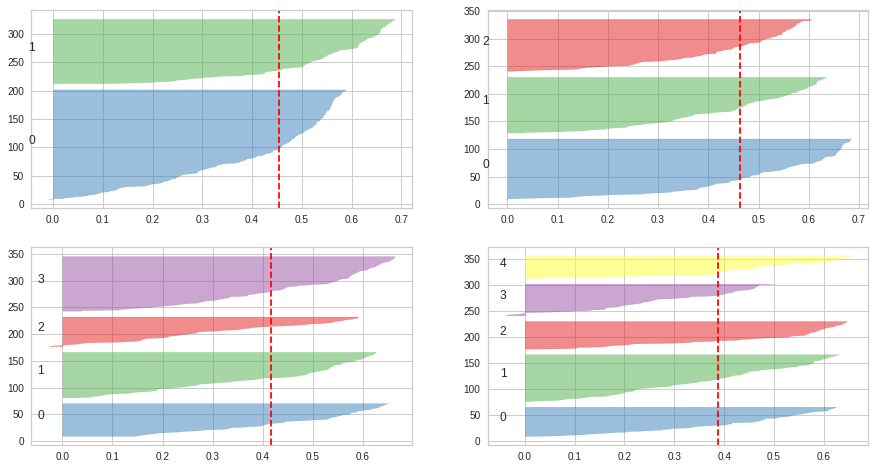

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer
fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(dato_org)

In [ ]:
savemat('y_km.mat',{'y_km_t_3':y_km_t_3,'y_km_t_2':y_km_t_2,
                    'y_km_f_3':y_km_f_3,'y_km_f_2':y_km_f_2,
                    'y_km_e_3':y_km_e_3,'y_km_e_2':y_km_e_2})

# Agrupación con spectral clustering

In [ ]:
from sklearn.cluster import SpectralClustering

In [ ]:
feature3 = list()
tam_ = list()
import numpy as np
for feat in range(len(features)):
  # tem = np.mean(features[feat][0][pos,:],axis=1)
  # tem = np.concatenate(features[feat][0][pos__,:],axis=0)
  tem = np.concatenate(temppo_v[feat])
  # feature3.append(np.concatenate(np.asarray([tem,tempo[feat]])))
  # feature3.append(np.co.ncatenate(np.asarray([tem)))
  feature3.append(tem)
  # feature_.append(np.concatenate(features[feat],axis=0))
  tam_.append(feature3[feat].shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


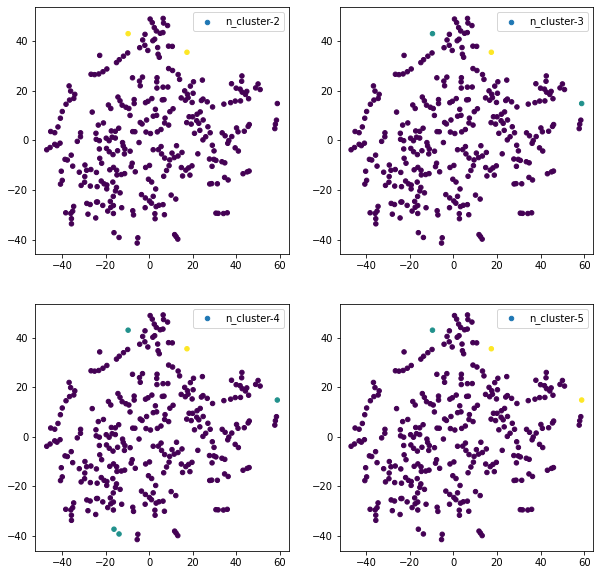

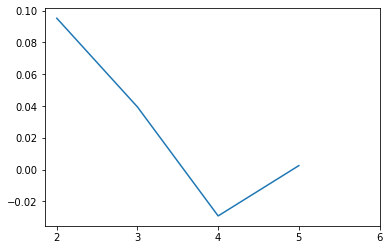

In [ ]:
n_clusters= 6
data = np.asarray(feature3)

dato_org = TSNE(n_components=2,random_state=0,perplexity=5).fit_transform(data)
silhouette_score_cluster = list()
f = plt.figure(figsize=(10,10))
f.add_subplot(2, 2, 1)
for i in range(2, n_clusters):
 sc = SpectralClustering(n_clusters=i,affinity='rbf',assign_labels='discretize',random_state=0,n_jobs=-1).fit(dato_org)
 silhouette_score_cluster.append(silhouette_score(dato_org,sc.labels_))
 f.add_subplot(2, 2, i-1)
 plt.scatter(dato_org[:,0], dato_org[:,1], s=20, c=sc.labels_, label="n_cluster-"+str(i))
 plt.legend()
plt.show()

dat_tem = silhouette_score_cluster
plt.figure()
plt.plot(silhouette_score_cluster)
plt.xticks([0,1,2,3,4], [2,3,4,5,6])
plt.show()

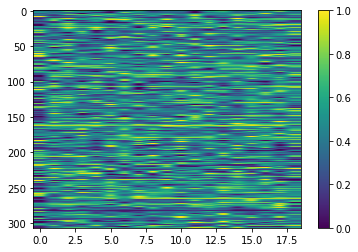

In [ ]:
data = np.asarray(feature3)
scaler = MinMaxScaler()
data=scaler.fit_transform(data.T).T
plt.imshow(data,aspect='auto')
plt.colorbar()
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


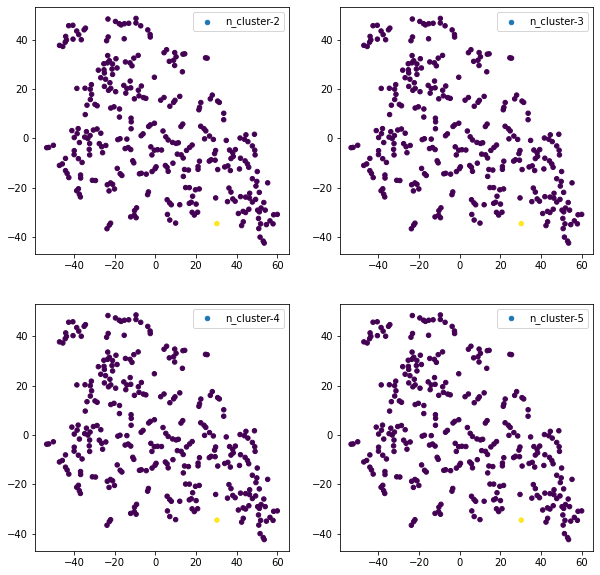

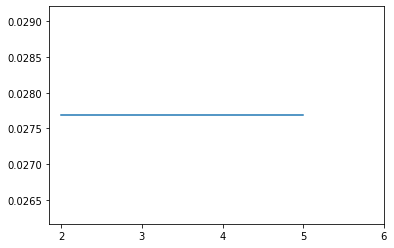

In [ ]:
dato_org = TSNE(n_components=2,random_state=0,perplexity=5).fit_transform(data)
silhouette_score_cluster = list()
f = plt.figure(figsize=(10,10))
f.add_subplot(2, 2, 1)
for i in range(2, n_clusters):
 sc = SpectralClustering(n_clusters=i,affinity='rbf',assign_labels='discretize',random_state=0,n_jobs=-1).fit(dato_org)
 silhouette_score_cluster.append(silhouette_score(dato_org,sc.labels_))
 f.add_subplot(2, 2, i-1)
 plt.scatter(dato_org[:,0], dato_org[:,1], s=20, c=sc.labels_, label="n_cluster-"+str(i))
 plt.legend()
plt.show()

dat_tem = silhouette_score_cluster
plt.figure()
plt.plot(silhouette_score_cluster)
plt.xticks([0,1,2,3,4], [2,3,4,5,6])
plt.show()

In [ ]:
feature4 = list()
tam_ = list()
import numpy as np
for feat in range(len(features)):
  # tem = np.mean(features[feat][0][pos,:],axis=1)
  # tem = np.concatenate(features[feat][0][pos__,:],axis=0)
  tem = np.concatenate(harmo[feat].reshape(-1,1))
  # feature3.append(np.concatenate(np.asarray([tem,tempo[feat]])))
  # feature3.append(np.co.ncatenate(np.asarray([tem)))
  feature4.append(tem)
  # feature_.append(np.concatenate(features[feat],axis=0))
  tam_.append(feature4[feat].shape)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding

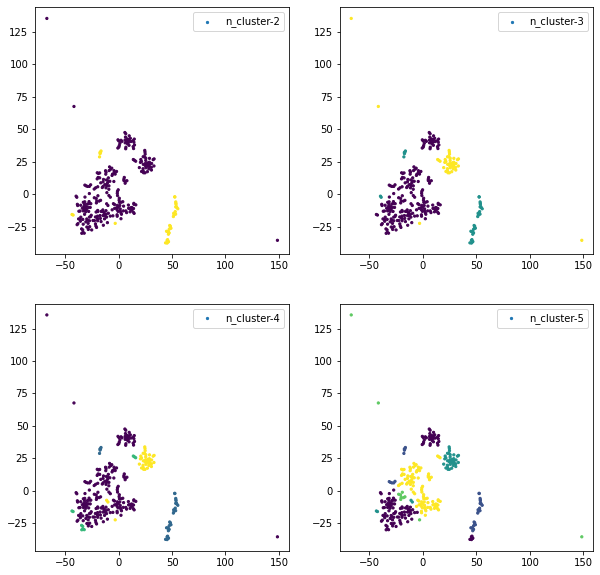

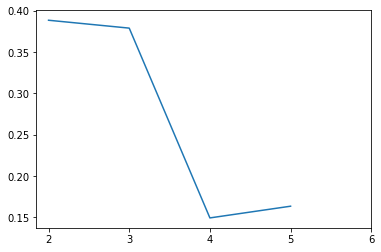

In [ ]:
n_clusters= 6
data = np.asarray(feature4)
dato_org = TSNE(n_components=2,random_state=0,perplexity=5).fit_transform(data)
silhouette_score_cluster = list()
f = plt.figure(figsize=(10,10))
f.add_subplot(2, 2, 1)
for i in range(2, n_clusters):
 sc = SpectralClustering(n_clusters=i,affinity='rbf',assign_labels='discretize',random_state=0,n_jobs=-1).fit(dato_org)
 silhouette_score_cluster.append(silhouette_score(dato_org,sc.labels_))
 f.add_subplot(2, 2, i-1)
 plt.scatter(dato_org[:,0], dato_org[:,1], s=5, c=sc.labels_, label="n_cluster-"+str(i))
 plt.legend()
plt.show()

dat_tem = silhouette_score_cluster
plt.figure()
plt.plot(silhouette_score_cluster)
plt.xticks([0,1,2,3,4], [2,3,4,5,6])
plt.show()

In [ ]:
filename = '/content/drive/Shareddrives/GCPDS/databases/Databases_musica/Estímulos/002 - copia.mp3'
audio_path = filename
x , sr = librosa.load(audio_path)
# extraer varias características
a_ = feature_extraction(x,sr,sr,sr*0.5)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [ ]:
pos__ = list(np.zeros((len(a_[1]))))
posi = [1] # 35,36
for po in posi:
  pos__[po] = 1
pos__ = np.asarray(pos__).astype(bool)
np.asarray(a_[1])[pos__] #0,1,2,3,5,34,35,36

array(['energy'], dtype='<U23')

In [ ]:
feature5 = list()
tam_ = list()
import numpy as np
for feat in range(len(features)):
  # tem = np.mean(features[feat][0][pos,:],axis=1)
  tem = np.concatenate(features[feat][0][pos__,:],axis=0)
  # tem = np.concatenate(temppo_v[feat])
  # feature3.append(np.concatenate(np.asarray([tem,tempo[feat]])))
  # feature3.append(np.co.ncatenate(np.asarray([tem)))
  feature5.append(tem)
  # feature_.append(np.concatenate(features[feat],axis=0))
  tam_.append(feature5[feat].shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


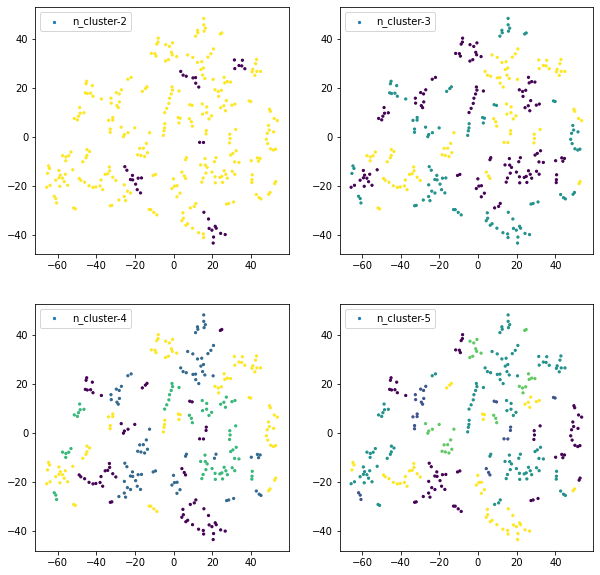

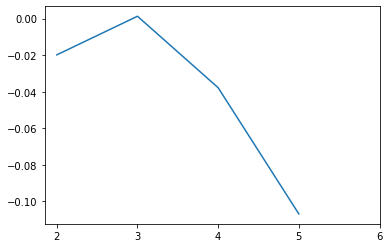

In [ ]:
n_clusters= 6
data = np.asarray(feature5)
dato_org = TSNE(n_components=2,random_state=0,perplexity=5).fit_transform(data)
silhouette_score_cluster = list()
f = plt.figure(figsize=(10,10))
f.add_subplot(2, 2, 1)
for i in range(2, n_clusters):
 sc = SpectralClustering(n_clusters=i,affinity='rbf',assign_labels='discretize',random_state=0,n_jobs=-1).fit(dato_org)
 silhouette_score_cluster.append(silhouette_score(dato_org,sc.labels_))
 f.add_subplot(2, 2, i-1)
 plt.scatter(dato_org[:,0], dato_org[:,1], s=5, c=sc.labels_, label="n_cluster-"+str(i))
 plt.legend()
plt.show()

dat_tem = silhouette_score_cluster
plt.figure()
plt.plot(silhouette_score_cluster)
plt.xticks([0,1,2,3,4], [2,3,4,5,6])
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler

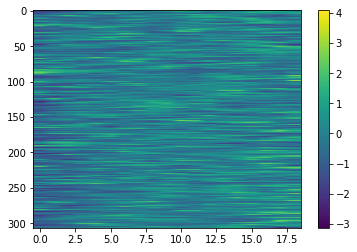

In [ ]:
data = np.asarray(feature5)
scaler = StandardScaler()
data=scaler.fit_transform(data.T).T
plt.imshow(data,aspect='auto')
plt.colorbar()
plt.show()

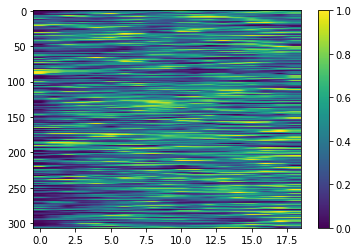

In [ ]:
data = np.asarray(feature5)
scaler = MinMaxScaler()
data=scaler.fit_transform(data.T).T
plt.imshow(data,aspect='auto')
plt.colorbar()
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


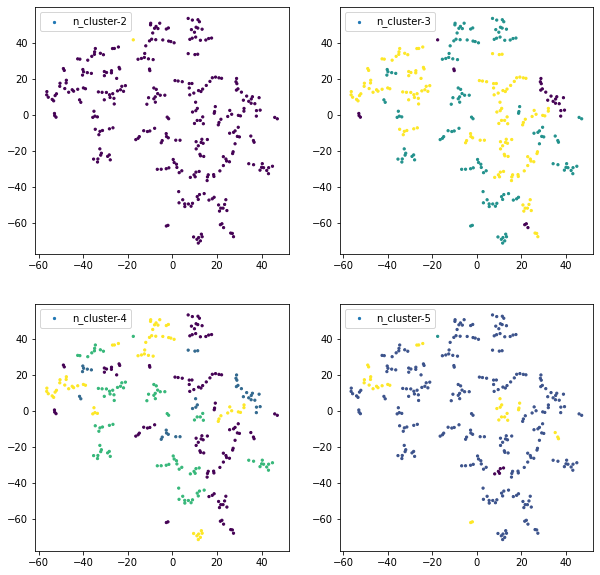

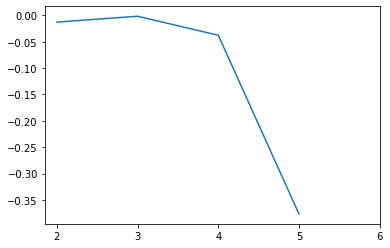

In [ ]:
dato_org = TSNE(n_components=2,random_state=0,perplexity=5).fit_transform(data)
silhouette_score_cluster = list()
f = plt.figure(figsize=(10,10))
f.add_subplot(2, 2, 1)
for i in range(2, n_clusters):
 sc = SpectralClustering(n_clusters=i,affinity='rbf',assign_labels='discretize',random_state=0,n_jobs=-1).fit(dato_org)
 silhouette_score_cluster.append(silhouette_score(dato_org,sc.labels_))
 f.add_subplot(2, 2, i-1)
 plt.scatter(dato_org[:,0], dato_org[:,1], s=5, c=sc.labels_, label="n_cluster-"+str(i))
 plt.legend()
plt.show()

dat_tem = silhouette_score_cluster
plt.figure()
plt.plot(silhouette_score_cluster)
plt.xticks([0,1,2,3,4], [2,3,4,5,6])
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


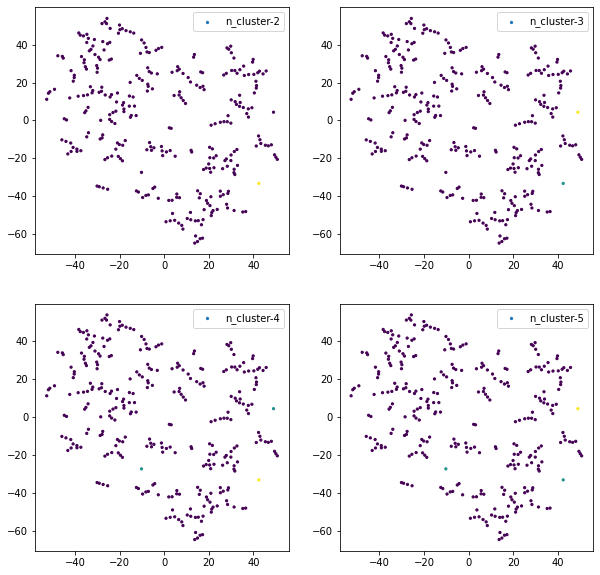

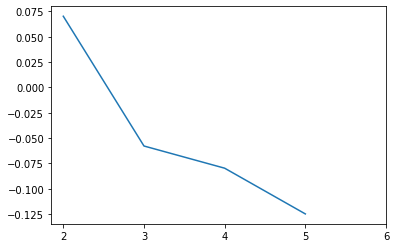

In [ ]:
dato_org = TSNE(n_components=2,random_state=0,perplexity=5).fit_transform(data)
silhouette_score_cluster = list()
f = plt.figure(figsize=(10,10))
f.add_subplot(2, 2, 1)
for i in range(2, n_clusters):
 sc = SpectralClustering(n_clusters=i,affinity='rbf',assign_labels='discretize',random_state=0,n_jobs=-1).fit(dato_org)
 silhouette_score_cluster.append(silhouette_score(dato_org,sc.labels_))
 f.add_subplot(2, 2, i-1)
 plt.scatter(dato_org[:,0], dato_org[:,1], s=5, c=sc.labels_, label="n_cluster-"+str(i))
 plt.legend()
plt.show()

dat_tem = silhouette_score_cluster
plt.figure()
plt.plot(silhouette_score_cluster)
plt.xticks([0,1,2,3,4], [2,3,4,5,6])
plt.show()